Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [2]:
## Update the path as required
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Update the paths of the train and test dataset as needed
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/DataSets/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/DataSets/Test')


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
tf.__version__

'2.8.2'

In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, resize images to the size img_height*img_width, while writting the dataset
## Write training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False
)##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False
)##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# These classes correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

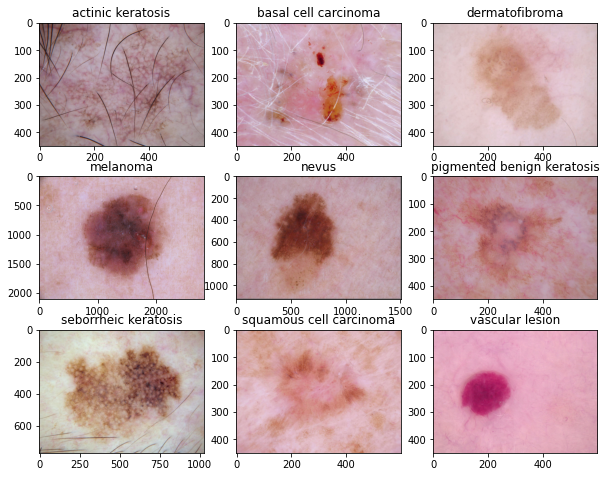

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,8))
for i in range(len(class_names)): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the base model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

num_class = len(class_names)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(num_class, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 102ms/step - loss: 2.0076 - accuracy: 0.2394 - val_loss: 1.8335 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6815 - accuracy: 0.3845 - val_loss: 1.6439 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5939 - accuracy: 0.4247 - val_loss: 1.7079 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5510 - accuracy: 0.4537 - val_loss: 1.4849 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4429 - accuracy: 0.5011 - val_loss: 1.5163 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4119 - accuracy: 0.5067 - val_loss: 1.4696 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3386 - accuracy: 0.5424 - val_loss: 1.3986 - val_accuracy: 0.5302
Epoch 8/20


### Visualizing training results

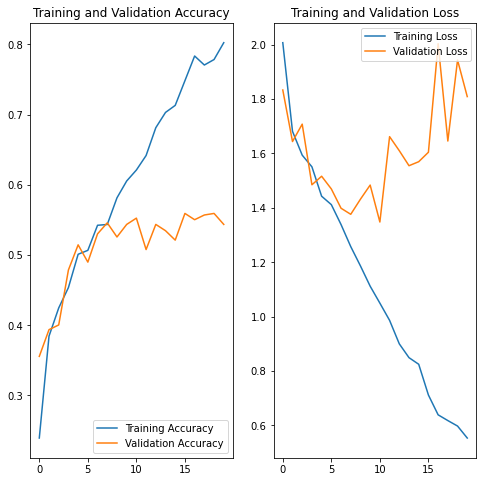

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings: The model is overrfitting as there is huge difference between training and testing accuracy.

In [19]:
#  visualize how your augmentation strategy works for one instance of training image.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2),
                             layers.experimental.preprocessing.RandomZoom(0.2)
])

### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_class = len(class_names)
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_class, activation = "softmax"))

### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 54ms/step - loss: 2.0592 - accuracy: 0.1975 - val_loss: 2.0323 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 2.0000 - accuracy: 0.2171 - val_loss: 1.9074 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.8034 - accuracy: 0.3315 - val_loss: 1.6600 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.6597 - accuracy: 0.3750 - val_loss: 1.5985 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.6407 - accuracy: 0.3917 - val_loss: 1.6147 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5807 - accuracy: 0.4252 - val_loss: 1.5861 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5402 - accuracy: 0.4503 - val_loss: 1.4771 - val_accuracy: 0.4855
Epoch 8/20
56

### Visualizing the results

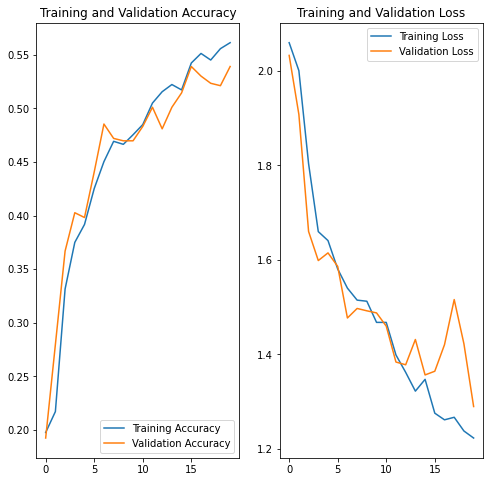

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

#### The overfitting is minimized to tolerable extent though accuracy is now low. As we see, the accuracy is proportional to epoch. So we will augment with more images and increase epoch.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:

import fnmatch

for i in class_names:
  dir_path = str(data_dir_train) + str("/") + str(i)
  count = len(fnmatch.filter(os.listdir(dir_path), '*.jpg'))
  print(i, count)


actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### **Findings:** 
#### - Which class has the least number of samples?
          Class seborrheic keratosis has least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
          Following dominating classes have proportionate samples in order :
            1. pigmented benign keratosis and melanoma 
            2. basal cell carcinoma and nevus





#### List out all labels and paths in a dataframe format for further analysis.

In [25]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN/DataSets/Train/act...,actinic keratosis
1,/content/gdrive/MyDrive/CNN/DataSets/Train/act...,actinic keratosis
2,/content/gdrive/MyDrive/CNN/DataSets/Train/act...,actinic keratosis
3,/content/gdrive/MyDrive/CNN/DataSets/Train/act...,actinic keratosis
4,/content/gdrive/MyDrive/CNN/DataSets/Train/act...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN/DataSets/Train/vas...,vascular lesion
2235,/content/gdrive/MyDrive/CNN/DataSets/Train/vas...,vascular lesion
2236,/content/gdrive/MyDrive/CNN/DataSets/Train/vas...,vascular lesion
2237,/content/gdrive/MyDrive/CNN/DataSets/Train/vas...,vascular lesion


#### Rectify the class imbalance
#### Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset= str(data_dir_train) + str("/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F52427090>: 100%|██████████| 500/500 [00:18<00:00, 27.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6ED64649D0>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6ED649A9D0>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6F523D1C50>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F57D8E050>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6ED6439D90>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6ED64B7B50>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F53A9B6D0>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/DataSets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6F52249050>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_854c4bd7-8b1a-4851-9c11-9674fad328dd.jpg',
 '/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_c4be3732-79cd-4646-81d5-4af737c1c312.jpg',
 '/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_80db5bdd-b2fc-46c6-b537-8594cfecf7ce.jpg',
 '/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_01c58129-5c86-4631-86a0-63c985dcb795.jpg',
 '/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_5b670c73-2466-4f5a-a879-6af14e1dd29b.jpg',
 '/content/gdrive/MyDrive/CNN/DataSets/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_a00b6a3d-1aa4-40d6-b2f9-86041fe47e41.jpg',
 '/content/gdrive/MyDr

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [35]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/DataSets/Train") ##"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create model (include normalization)

In [37]:
## your code goes here
num_class = len(class_names)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_class, activation = "softmax"))

####  Compile  model 

In [38]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

####   Train  model

In [39]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 248ms/step - loss: 1.9694 - accuracy: 0.2476 - val_loss: 1.6640 - val_accuracy: 0.3808
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 1.5429 - accuracy: 0.4024 - val_loss: 1.4355 - val_accuracy: 0.4499
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4268 - accuracy: 0.4603 - val_loss: 1.3648 - val_accuracy: 0.4981
Epoch 4/30
169/169 [==============================] - 32s 177ms/step - loss: 1.3403 - accuracy: 0.5043 - val_loss: 1.4062 - val_accuracy: 0.4974
Epoch 5/30
169/169 [==============================] - 31s 175ms/step - loss: 1.2265 - accuracy: 0.5376 - val_loss: 1.2006 - val_accuracy: 0.5776
Epoch 6/30
169/169 [==============================] - 30s 173ms/step - loss: 1.1518 - accuracy: 0.5703 - val_loss: 1.2412 - val_accuracy: 0.5397
Epoch 7/30
169/169 [==============================] - 30s 174ms/step - loss: 1.0510 - accuracy: 0.6076 - val_loss: 1.1074 - val_ac

####   Visualize the model results

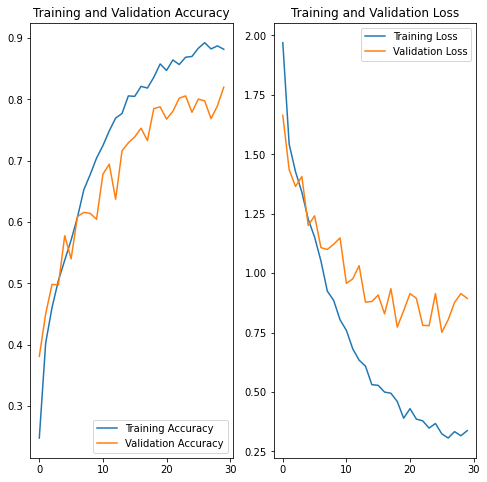

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results and Conclusions:
Yes. Class rebalance was helpful. It resulted in model with higher accuracy and stability. There is still a bit overfitting and maybe it can be solved by more dropouts or adding more layers. Alternatively adding more augmentation can also help a lot in better model.
